# Read all ensemble members

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [7]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Geospatial help

In [105]:
import geopandas as gpd
from typing import Any, Optional, Dict, List, Tuple


d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"
world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")

In [110]:
def create_geospatial_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df.join(points), crs="epsg:4326")


def _plot_geospatial(metric_data: gpd.GeoDataFrame, column: str, ax: Any, legend: bool = True, cax: Optional[Any] = None, kwargs: Dict = {}):
    # plot the chloropleth
    metric_data.to_crs(epsg=4326).plot(column, ax=ax, cax=cax, legend=legend, **kwargs);

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.axis('off')
    return ax

# Read ensemble members

In [8]:
from scripts.drafts.io_results import read_ensemble_member_results

In [16]:
ensemble_dir = data_dir / "runs/ensemble_LANE"
assert ensemble_dir.exists()
ensemble_ds = read_ensemble_member_results(ensemble_dir)

Loading Ensemble Members: 0it [00:00, ?it/s]

found ensemble mean


Loading Ensemble Members: 9it [00:07,  1.16it/s]


In [17]:
ensemble_ds

<xarray.Dataset>
Dimensions:     (member: 9, station_id: 669, time: 4018)
Coordinates:
  * station_id  (station_id) int64 10002 10003 1001 101002 ... 96002 96004 97002
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * member      (member) object 'mean' 'ensemble1' ... 'ensemble5' 'ensemble3'
Data variables:
    obs         (member, station_id, time) float32 2.37 2.49 2.42 ... 0.73 0.79
    sim         (member, station_id, time) float32 2.143 2.606 ... 0.985 0.9574

# Calculate the errors

In [50]:
def _member_dimension_to_variable(ensemble_ds: xr.Dataset):
    assert "member" in ensemble_ds.coords
    member_ds = []
    for i, member in enumerate(ensemble_ds.member):
        temp_ = ensemble_ds.sel(member=member).rename({"sim": str(member.values)}).drop("member")

        if i != 0:
            temp_.drop("obs")
        member_ds.append(temp_)

    return xr.merge(member_ds)


ensemble_preds = _member_dimension_to_variable(ensemble_ds)

In [51]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

if "ensemble_errors" not in globals().keys():
    ensemble_errors = calculate_all_data_errors(ensemble_preds, decompose_kge=True, yilmaz_errors=True)

Errors: 100%|██████████| 9/9 [10:22<00:00, 69.16s/it]


In [89]:
from typing import DefaultDict
from collections import defaultdict


def invert_errors_dict(all_errors: DefaultDict) -> DefaultDict:
    model = [k for k in ensemble_errors.keys()][0]
    metrics = ensemble_errors[model].columns
    all_metrics_list = defaultdict(list)
    for model in ensemble_errors.keys():
        for metric in metrics:
            all_metrics_list[metric].append(ensemble_errors[model][metric].rename(model))

    all_metrics = defaultdict()
    for metric in all_metrics_list.keys():
        df = pd.concat(all_metrics_list[metric], axis=1)
        all_metrics[metric] = df

    return all_metrics
    

all_metrics = invert_errors_dict(ensemble_errors)

# What are the Variabilities in Metrics?

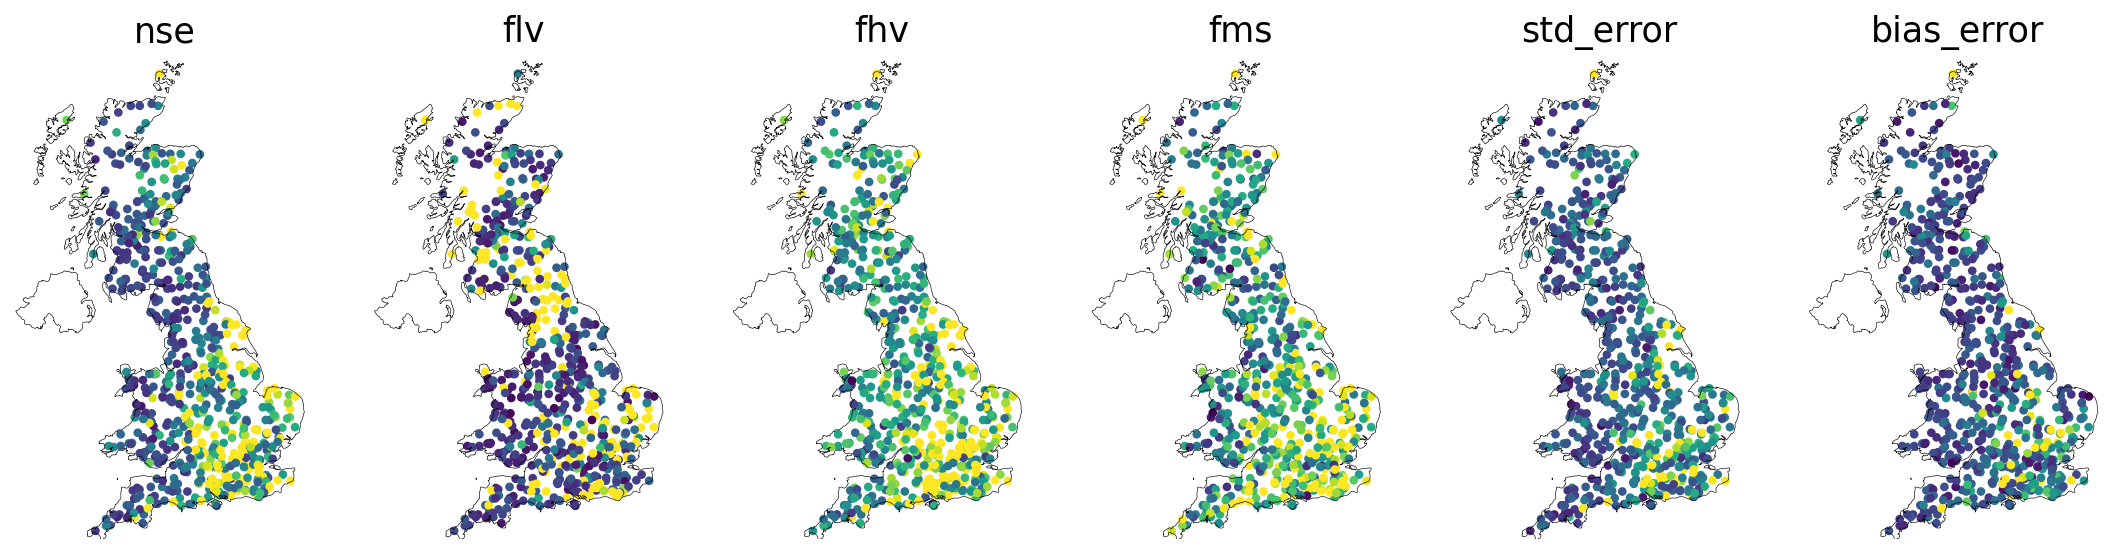

In [271]:
metric = "bias_error"
scale = 0.6
markersize = 10
fig, axs = plt.subplots(1, 6, figsize=(5*scale*6, 8*scale*1))

lookup = {
    "nse":{"vmin": 0.0, "vmax": 0.025,  "markersize": markersize},
    "flv":{"vmin": None, "vmax": 100,  "markersize": markersize},
    "fhv":{"vmin": None, "vmax": 5,  "markersize": markersize},
    "fms":{"vmin": None, "vmax": 8,  "markersize": markersize},
    "std_error":{"vmin": None, "vmax": 0.08,  "markersize": markersize},
    "bias_error":{"vmin": None, "vmax": 0.08,  "markersize": markersize},
    "":{"vmin": None, "vmax": None,  "markersize": markersize},
}

for ix, metric in enumerate(['nse', 'flv', 'fhv', 'fms', 'std_error', 'bias_error']):
    ax = axs[ix]
    _plot_geospatial(
        create_geospatial_data(all_metrics[metric].drop("mean", axis=1).std(axis=1).to_frame(name=metric)),
        column=metric,
        ax=ax,
        kwargs=lookup[metric],
        legend=False
    );
    ax.set_title(metric)

In [281]:
from scripts.drafts.plots import plot_cdf
scale = 0.6
FIGSIZE = (12*scale, 8*scale)

clipping_lookup = {
    "nse": (0, 1.),
    "kge": (0, 1),
    "correlation": (0.5, 1),
    "bias_ratio": (0, 1.5),
    "variability_ratio": (0, 1.5),
    "bias_error": (-0.5, 0.5),
    "std_error": (-0.5, 0.5),
    "bias_error_pct": (-50, 50),
    "std_error_pct": (-50, 50),
    "flv": (-100, 100), 
    "fms": (-100, 100), 
    "fhv": (-100, 100), 
}

In [ ]:
f, ax = plt.subplots()
metric = "flv"
for col in all_metrics[metric].columns:
    sns.distplot(all_metrics[metric][col], hist=False, kde_kws=dict(cumulative=True), label=col, ax=ax)
ax.get_legend().remove()

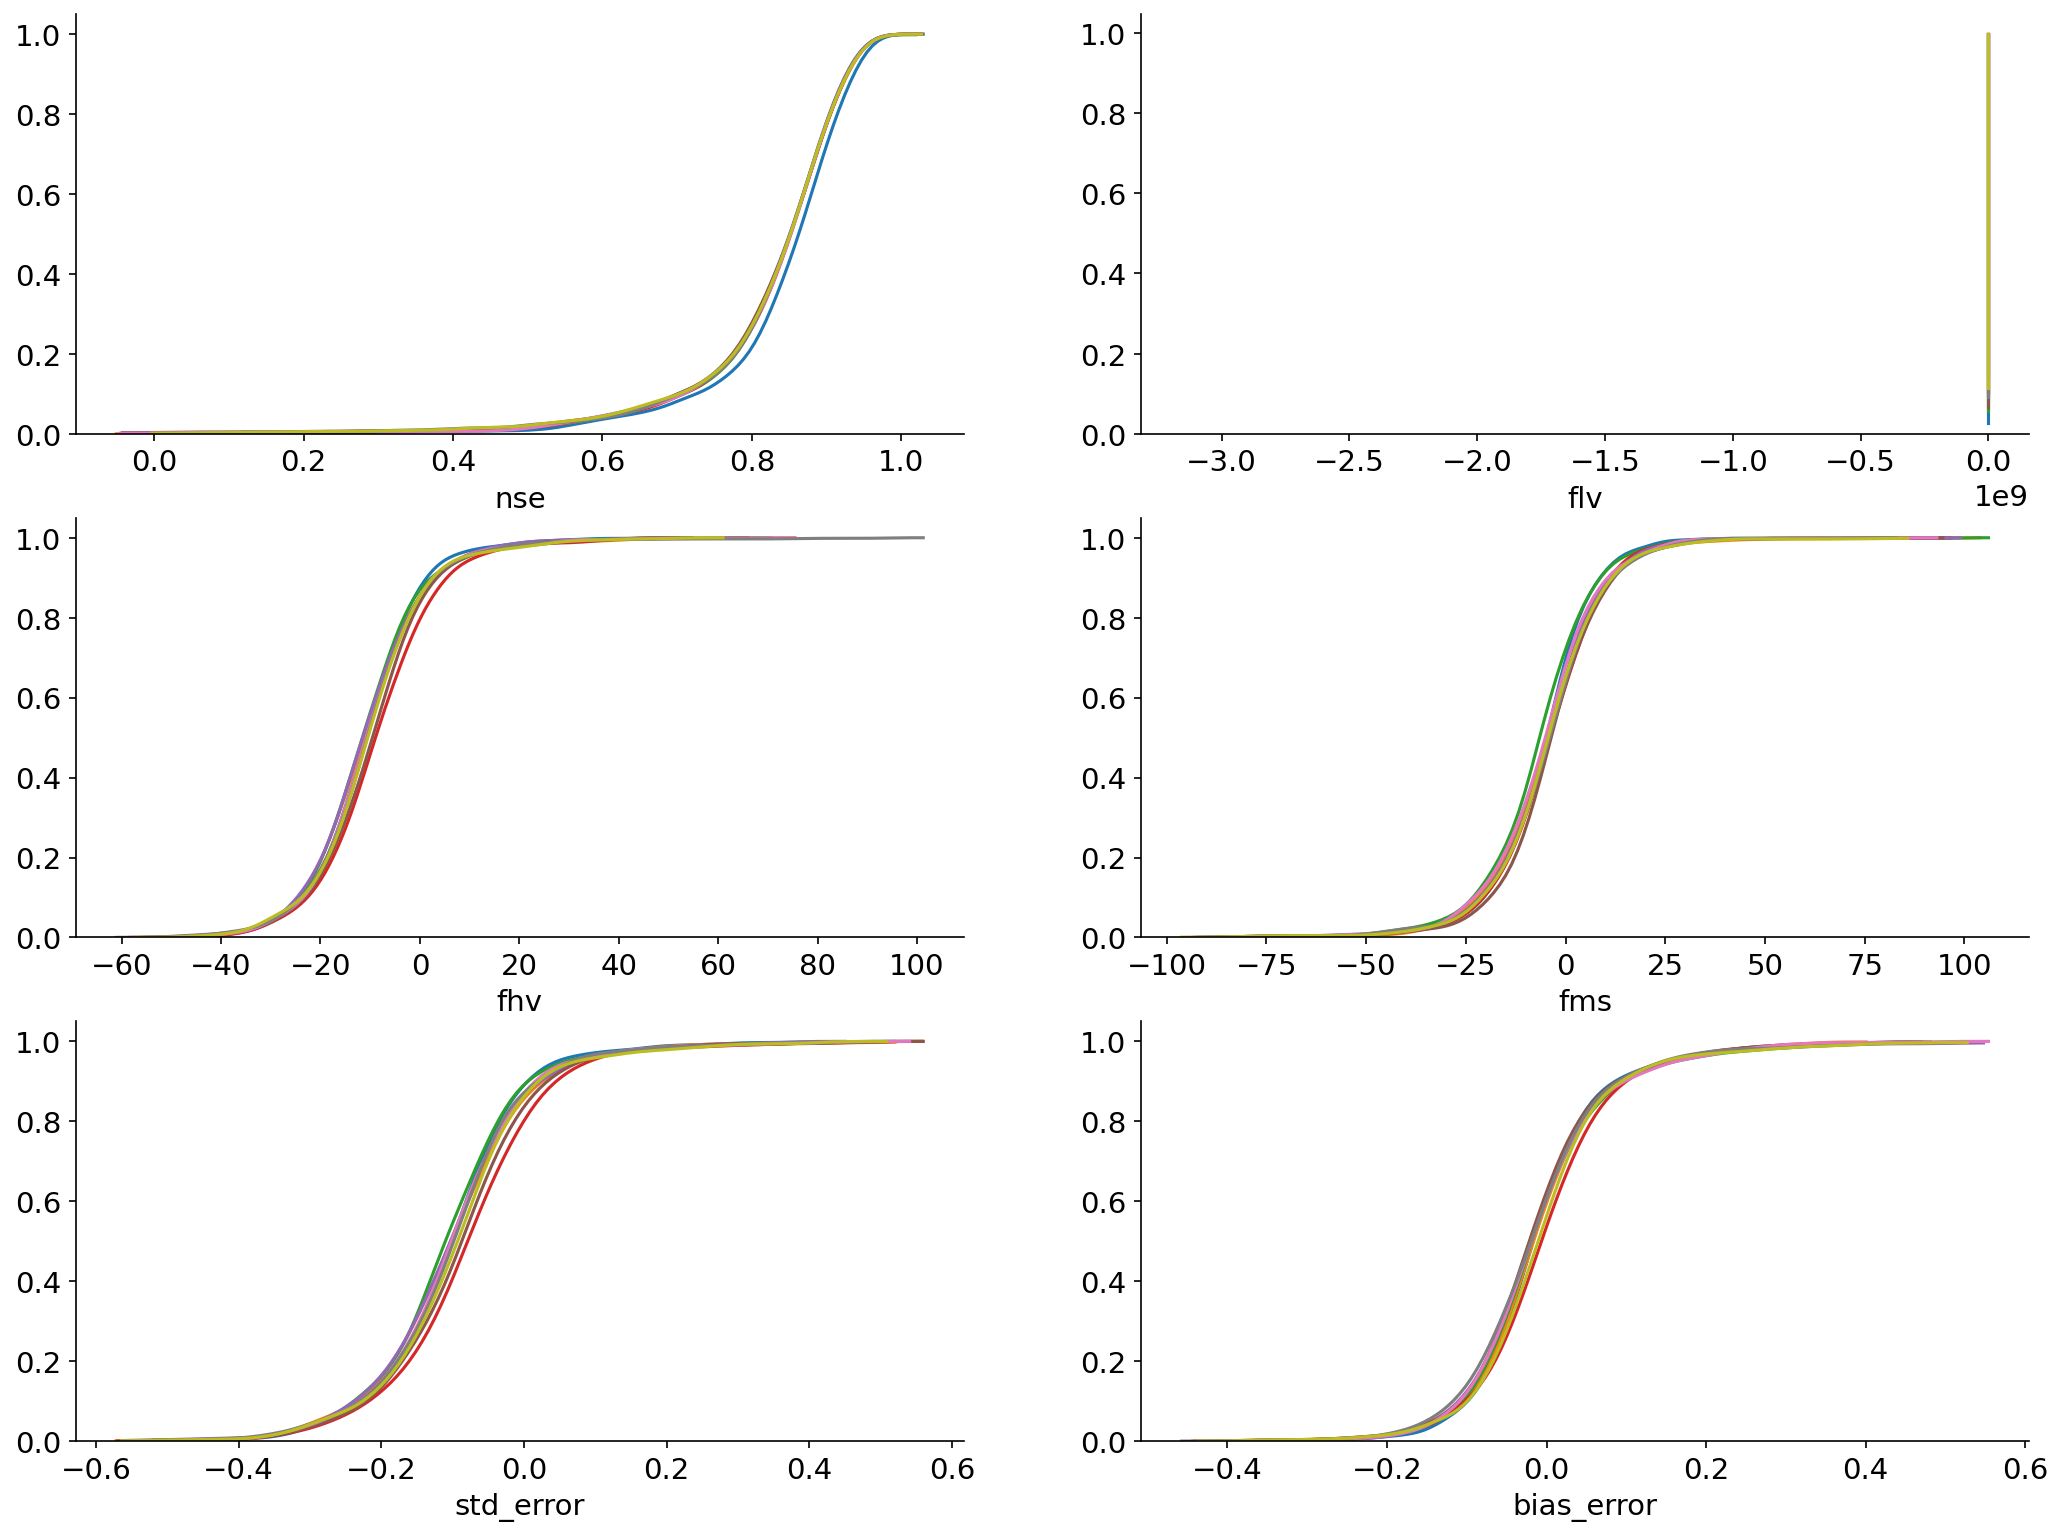

In [306]:
metric = "nse"
scale = 0.7
f, axs = plt.subplots(3, 2, figsize=(12*scale*2, 6*scale*3))

for ix, metric in enumerate(['nse', 'flv', 'fhv', 'fms', 'std_error', 'bias_error']):
    ax = axs[np.unravel_index(ix, (3, 2))]
    metric_data = all_metrics[metric]
    for col in all_metrics[metric].columns:
        sns.distplot(all_metrics[metric][col], hist=False, kde_kws=dict(cumulative=True, clip=clipping_lookup[metric]), label=col, ax=ax)
    ax.set_xlabel(metric)
    ax.get_legend().remove()

    sns.despine()

# Calculate basic uncertainties

In [187]:
# mad = (ensemble_ds.drop("obs") - ensemble_ds.drop("obs").median(dim=["member"])).median(dim=["member", "time"]).to_dataframe()

In [197]:
# (ensemble_ds.drop("obs") - ensemble_ds.drop("obs").median(dim=["member", "time"])).median(dim=["member", "time"]).to_dataframe()

In [198]:
# normalise the variability of prediction by 
std_norm_q = (ensemble_ds.drop("obs").std(dim=["member", "time"]) / static.q_mean).to_dataframe()

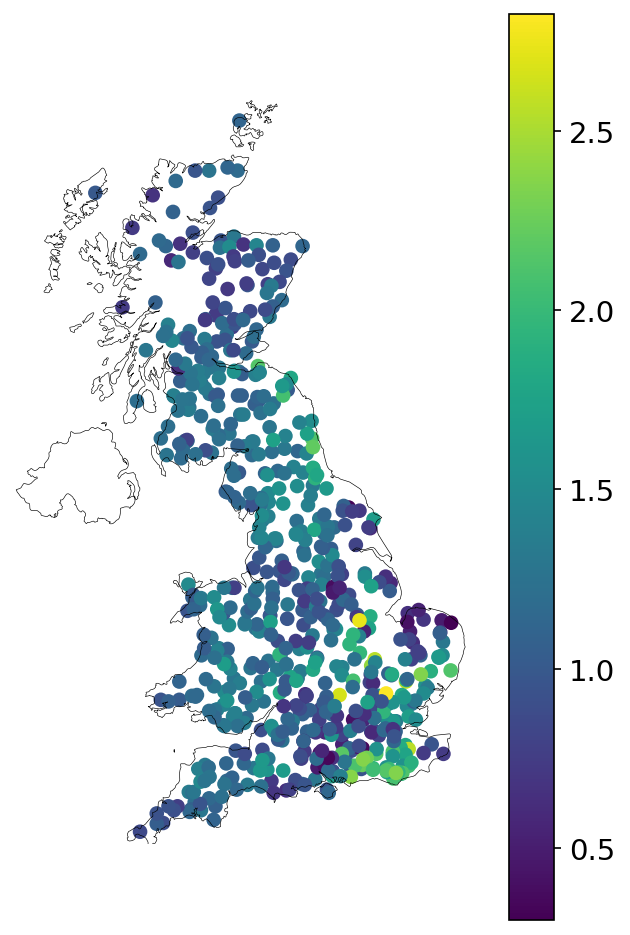

In [199]:
fig, ax = plt.subplots(figsize=(5, 8))

_plot_geospatial(
    create_geospatial_data(std_norm_q),
    column="sim",
    ax=ax
);

# Correlations

In [206]:
from scipy.stats import spearmanr, kendalltau

def calculate_correlation_with_static_features(metric_values: pd.Series, static_df: pd.DataFrame, method: str = "spearman") -> pd.DataFrame:
    func_lookup = {
        "kendall": kendalltau,
        "spearman": spearmanr,
    }
    out = defaultdict(list)
    
    static_df = static_df.loc[metric_values.index]
    assert all(static_df.index == metric_values.index)
    
    for feature in static_df.columns:
        result = func_lookup[method](metric_values, static_df[feature])
        out["correlation"].append(result.correlation)
        out["pvalue"].append(result.pvalue)
        out["variable"].append(feature)

    rank_correlations = pd.DataFrame(out)
    return rank_correlations

In [225]:
important_features = [
    # topography
    "dpsbar",
    "elev_mean",
    "elev_min",
    "elev_max",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]


metric = "correlation"

## Calculate correlations 
for variance_metric
corr_df = calculate_correlation_with_static_features(std_norm_q, static[important_features].to_dataframe(), method="spearman")
corr_df["model"] = "LSTM"

## Assign the extra columns (for the plotter below)
corr_df["significant"] = corr_df["pvalue"] < 0.001
corr_df["positive"] = corr_df["correlation"] > 0

# Sort Model columns for plotting
model_sorter = ["LSTM", "EALSTM", "TOPMODEL", "SACRAMENTO", "ARNOVIC", "PRMS"]
variable_sorter = important_features


corr_df["model"] = corr_df["model"].astype("category")
corr_df["model"].cat.set_categories(model_sorter, inplace=True)

# Sort Variable columns for plotting
corr_df["variable"] = corr_df["variable"].astype("category")
corr_df["variable"].cat.set_categories(variable_sorter, inplace=True)
corr_df = corr_df.sort_values(["model", "variable"])

corr_df.head()

,correlation,pvalue,variable,significant,positive,model
0,-0.105750,0.006185,dpsbar,False,False,LSTM
1,-0.110319,0.004279,elev_mean,False,False,LSTM
2,0.005005,0.897195,elev_min,False,True,LSTM
3,-0.121138,0.001696,elev_max,False,False,LSTM
4,-0.085052,0.027826,q_mean,False,False,LSTM


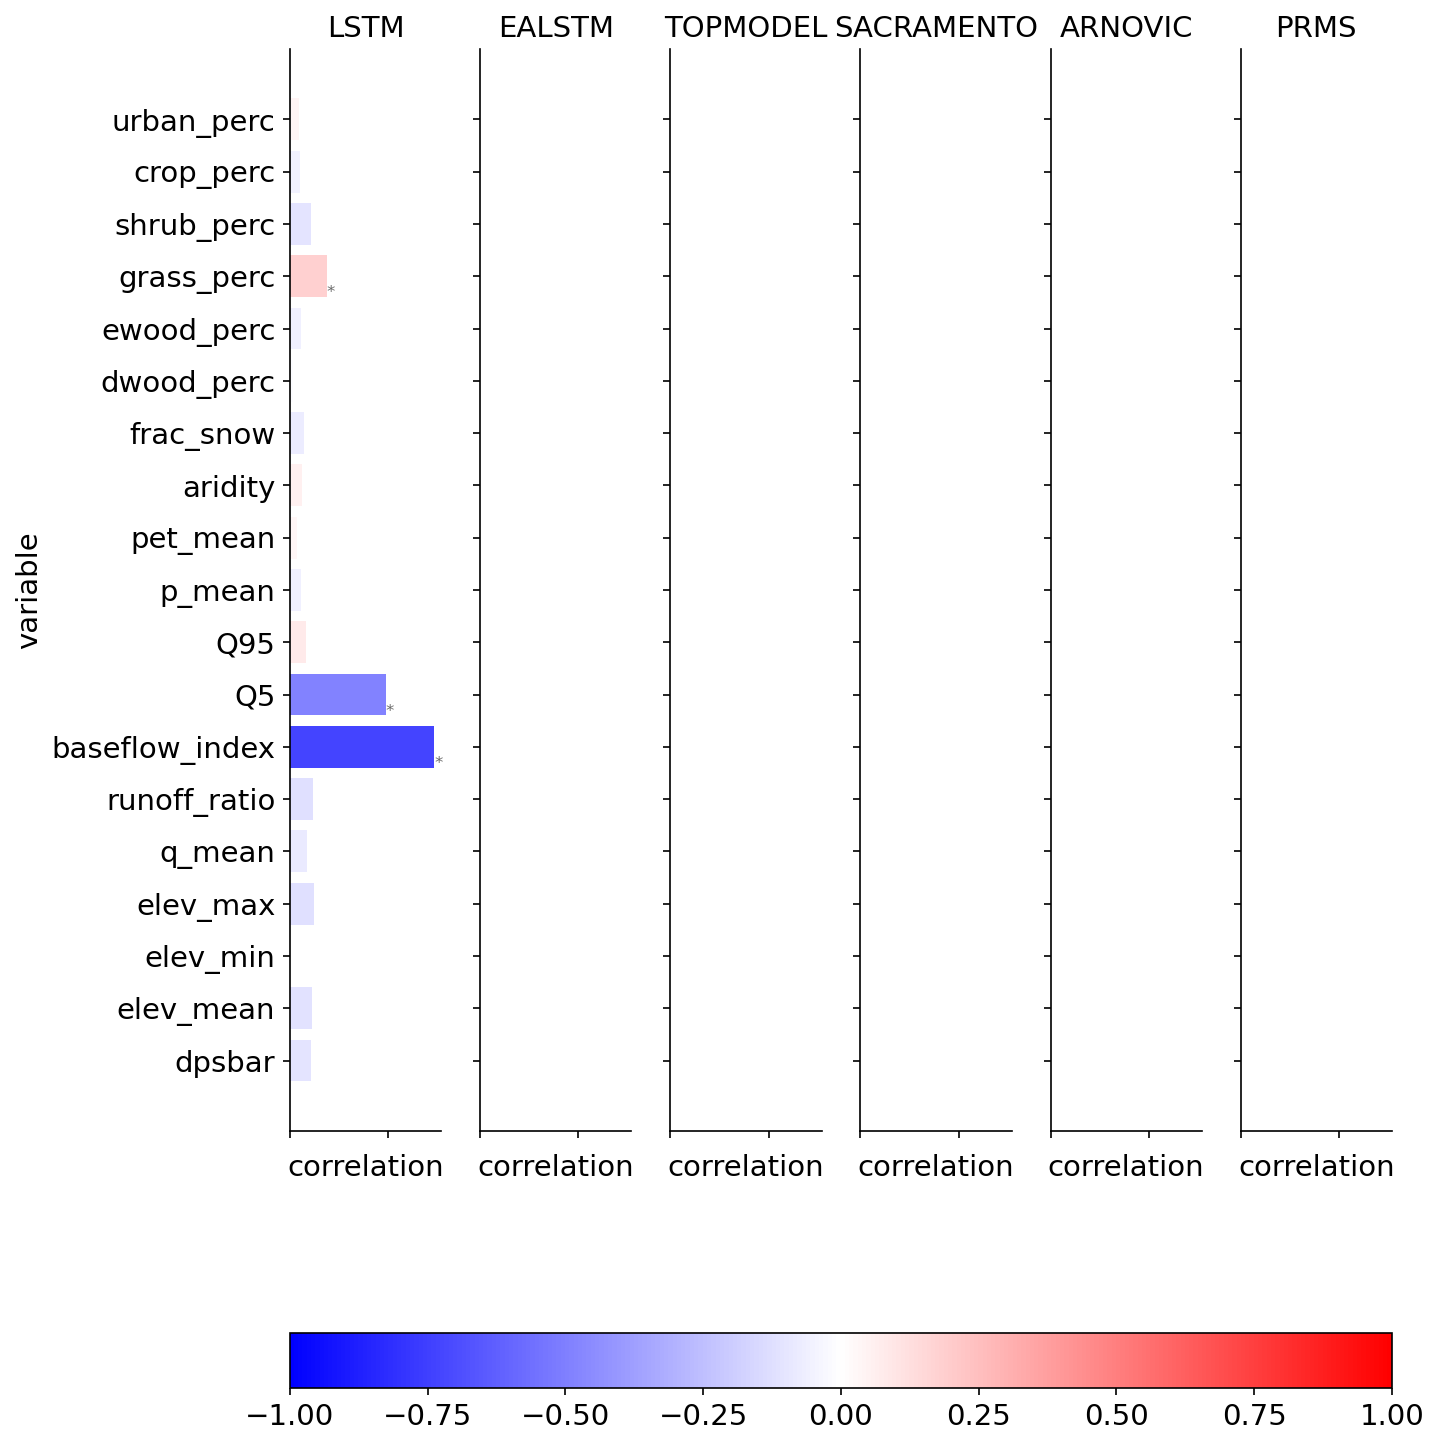

In [226]:
# https://stackoverflow.com/questions/65749781/create-a-table-of-multiple-mini-barplots-in-python/65750091#65750091

from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable


def assign_to_significant_bars(significant: pd.Series):
    ax = plt.gca()
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    significant = significant.to_list()
    list_of_patches = [i for ix, i in enumerate(ax.patches) if significant[ix]]
    for i in list_of_patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_width(), i.get_y(), "*", fontsize=8, color='dimgrey')


# f, ax = plt.subplots(figsize=(12, 8))
norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
cmap = plt.get_cmap('bwr')

def my_bar_plot(x, y, significant, **kwargs):
    plt.barh(y=y, width=abs(x), color=cmap(norm(x)))
    assign_to_significant_bars(significant)
    ax = plt.gca()
    ax.set_xticklabels([""])

g = sns.FacetGrid(data=corr_df, col='model', height=5, aspect=0.16, sharex=True, sharey=True, size=10)
g.map(my_bar_plot, 'correlation', 'variable', "significant")
g.set_titles(col_template="{col_name}")
g.fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', ax=g.axes, fraction=0.05);
